## Importação das bibliotecas

In [16]:
import re

# MLflow
import mlflow
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor

# Pacotes Estatisticos
from scipy.stats import norm

# Feature Selection
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    root_mean_squared_error,
)

# Metricas
from sklearn.model_selection import (
    RandomizedSearchCV,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

### Configurações

In [17]:
# Define o número máximo de colunas exibidas pelo pandas
pd.set_option('display.max_columns', 200)

# Define o pandas para exibir os números em ponto flutuante com duas casas decimais
pd.set_option('display.float_format', '{:.4f}'.format)

# Define o pandas para evitar a conversão silenciosa (downcasting) de tipos de dados
pd.set_option('future.no_silent_downcasting', True)

## Leitura dos dados

In [18]:
# Caminho do arquivo que contém os dados brutos
raw_data_path = '../data/raw/imoveis.json'
df = pd.read_json(raw_data_path, lines=True)
df.head()

,codigo_anunciante,codigo_zapimoveis,dtCriacao,dtColeta,imobiliaria,nrPreco,condominio,iptu,endereco,floorSize,numberOfRooms,numberOfBathroomsTotal,numberOfParkingSpaces,floorLevel,FURNISHED,POOL,ELEVATOR,LAVABO,SAUNA,PORCELAIN,INTERCOM,AIR_CONDITIONING,numberOfSuites,PETS_ALLOWED,BALCONY,BACKYARD,SPORTS_COURT,BARBECUE_GRILL,LAUNDRY,ALARM_SYSTEM,SERVICE_AREA,GARDEN,DEPOSIT,PLAYGROUND,SEA_VIEW,GOURMET_BALCONY,KITCHEN,PARTY_HALL,CABLE_TV,KITCHEN_CABINETS,SAFETY_CIRCUIT,GATED_COMMUNITY,HEATING,CONCIERGE_24H,WATCHMAN,GOURMET_SPACE,GYM,BICYCLES_PLACE,DINNER_ROOM,PAVED_STREET,RECEPTION,CLOSET,CARETAKER,ARMORED_SECURITY_CABIN,RECREATION_AREA,ELECTRONIC_GATE,INTERNET_ACCESS,BLINDEX_BOX,BEDROOM_WARDROBE,BATHROOM_CABINETS,DISABLED_ACCESS,HOME_OFFICE,SPA,TENNIS_COURT,INDOOR_SOCCER,MOUNTAIN_VIEW,CHILDRENS_POOL,DECK,MASSAGE_ROOM,GRASS,CINEMA,SQUASH,COPA,AMERICAN_KITCHEN,ELECTRIC_GENERATOR,TOYS_PLACE,PANTRY,BAR,FIREPLACE,GAMES_ROOM,WALL_BALCONY,PLANNED_FURNITURE,ALUMINUM_WINDOW,NATURAL_VENTILATION,LARGE_WINDOW,EMPLOYEE_DEPENDENCY,ENTRANCE_HALL,SERVICE_BATHROOM,INTEGRATED_ENVIRONMENTS,HIGH_CEILING_HEIGHT,LARGE_ROOM,COLD_FLOOR,WHIRLPOOL,BARBECUE_BALCONY,BUILTIN_WARDROBE,SQUARE,HEATED_POOL,TEEN_SPACE,SERVICE_ROOM,STAIR,FULL_FLOOR,FITNESS_ROOM,LARGE_KITCHEN,PANORAMIC_VIEW,PLATED_GAS,LAMINATED_FLOOR,ADULT_POOL,GREEN_SPACE,PIZZA_OVEN,BEAUTY_CENTER,SECURITY_CAMERA,SECURITY_CABIN,COWORKING,COOKER,SOLARIUM,FOOTBALL_FIELD,GOURMET_KITCHEN,BATHTUB,SANCA,PET_SPACE,SERVICE_ENTRANCE,PRIVATE_POOL,DIGITAL_LOCKER,WOOD_FLOOR,VALET_PARKING,PARKING,MEZZANINE,LUNCH_ROOM,PATROL,GLASS_WALL,SMALL_ROOM,CORNER_PROPERTY,ADMINISTRATION,GAS_SHOWER,MEETING_ROOM,MASSAGE,TREE_CLIMBING,LIBRARY,HIKING_TRAIL,SMART_CONDOMINIUM,POOL_BAR,RESTAURANT,COVENTION_HALL,SOUNDPROOFING,SIDE_ENTRANCE,ZEN_SPACE,REDARIO,HALF_FLOOR,COVERED_POOL,GUEST_PARKING,REVERSIBLE_ROOM,STORES,BEAUTY_ROOM,COVERAGE,ELETRIC_CHARGER,SEMI_OLYMPIC_POOL,ECO_GARBAGE_COLLECTOR,VINYL_FLOOR,SLAB,LAKE_VIEW,FRUIT_TREES,HOT_TUB,THERMAL_INSULATION,DIVIDERS,WALLS_GRIDS,FREEZER
0,AP6730,2688030535,03/02/2024,29/05/2025,Mais Imóveis Santos,R$ 2.650.000,R$ 2.200,R$ 667,Avenida Coronel Joaquim Montenegro - Aparecida...,180 m²,3 quartos,4 banheiros,3 vagas,11 andar,Mobiliado,Piscina,Elevador,Lavabo,Sauna,Porcelanato,Interfone,Ar-condicionado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AP14313,2756573916,13/11/2024,29/05/2025,R3 Imóveis,R$ 3.720.000,R$ 1.945,R$ 945,"Avenida Doutor Epitácio Pessoa, 131 - Embaré, ...",204 m²,3 quartos,5 banheiros,3 vagas,31 andar,NaN,Piscina,Elevador,Lavabo,NaN,Porcelanato,Interfone,Ar-condicionado,3 suítes,Aceita animais,Varanda,Quintal,Quadra poliesportiva,Churrasqueira,Lavanderia,Sistema de alarme,Área de serviço,Jardim,Depósito,Playground,Vista para o mar,Varanda gourmet,Cozinha,Salão de festas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AP04984,2806818830,16/05/2025,29/05/2025,Ricci Consultoria Imobiliaria,R$ 430.000,R$ 585,R$ 138,"Rua Pará - Campo Grande, Santos - SP",81 m²,3 quartos,1 banheiro,1 vaga,1

In [19]:
print('O dataset contém:')
print(f'{df.shape[0]} amostras')
print(f'{df.shape[1]} colunas')
print(f'{df.isna().sum().sum()} valores faltantes')
print(f'{df.duplicated().sum()} amostras duplicadas')

O dataset contém:
5698 amostras
166 colunas
811965 valores faltantes
488 amostras duplicadas


### Padronização de Nomes de Colunas

Os nomes das colunas foram padronizados para o português, facilitando a interpretação e o uso das variáveis ao longo do notebook.

In [20]:
df.rename(
    columns={
        'condominio': 'nrCondominio',
        'iptu': 'nrIptu',
        'floorSize': 'nrArea(m2)',
        'numberOfRooms': 'nrQuartos',
        'numberOfBathroomsTotal': 'nrBanheiros',
        'numberOfParkingSpaces': 'nrVagas',
        'floorLevel': 'nrAndar',
        'numberOfSuites': 'nrSuites',
    },
    inplace=True,
)

### Tratamento de valores duplicados e ausentes

Removemos as amostras duplicadas para garantir que cada registro no dataset seja único. Isso é importante para evitar que registros repetidos distorçam os resultados das análises.

In [21]:
# Retirando os valores duplicados
df.drop_duplicates(subset='codigo_zapimoveis', inplace=True)

Os valores ausentes foram preenchidos com 0. Essa abordagem foi adotada para evitar problemas em análises futuras, mas é importante avaliar se essa substituição faz sentido para cada variável. Os valores ausentes nesse dataset são devidos a falta de preenchimento da caracteristica do imóvel.

In [22]:
# Preenchendo os valores faltantes com 0
df.fillna(0, inplace=True)

### Limpeza de Variáveis Quantitativas

As variáveis quantitativas foram convertidas para o tipo `int`, removendo caracteres não numéricos e preenchendo valores ausentes com `0`. Essa etapa é essencial para garantir que os dados estejam no formato correto para análises numéricas.

In [23]:
int_cols = [
    'nrPreco',
    'nrCondominio',
    'nrIptu',
    'nrArea(m2)',
    'nrQuartos',
    'nrBanheiros',
    'nrVagas',
    'nrAndar',
    'nrSuites',
]

for col in int_cols:
    df[col] = df[col].replace(r'[^\d]', '', regex=True)
    df[col] = df[col].replace('', '0')
    df[col] = df[col].fillna(0)
    df[col] = df[col].astype(int)

In [24]:
int_cols = [
    'nrPreco',
    'nrCondominio',
    'nrIptu',
    'nrArea(m2)',
    'nrQuartos',
    'nrBanheiros',
    'nrVagas',
    'nrAndar',
    'nrSuites',
]


limite_inferior, limite_superior = norm.interval(
    confidence=0.99, loc=df['nrArea(m2)'].mean(), scale=df['nrArea(m2)'].std()
)
df[df['nrArea(m2)'] <= limite_inferior].sort_values(
    'nrArea(m2)', ascending=False
)

,codigo_anunciante,codigo_zapimoveis,dtCriacao,dtColeta,imobiliaria,nrPreco,nrCondominio,nrIptu,endereco,nrArea(m2),nrQuartos,nrBanheiros,nrVagas,nrAndar,FURNISHED,POOL,ELEVATOR,LAVABO,SAUNA,PORCELAIN,INTERCOM,AIR_CONDITIONING,nrSuites,PETS_ALLOWED,BALCONY,BACKYARD,SPORTS_COURT,BARBECUE_GRILL,LAUNDRY,ALARM_SYSTEM,SERVICE_AREA,GARDEN,DEPOSIT,PLAYGROUND,SEA_VIEW,GOURMET_BALCONY,KITCHEN,PARTY_HALL,CABLE_TV,KITCHEN_CABINETS,SAFETY_CIRCUIT,GATED_COMMUNITY,HEATING,CONCIERGE_24H,WATCHMAN,GOURMET_SPACE,GYM,BICYCLES_PLACE,DINNER_ROOM,PAVED_STREET,RECEPTION,CLOSET,CARETAKER,ARMORED_SECURITY_CABIN,RECREATION_AREA,ELECTRONIC_GATE,INTERNET_ACCESS,BLINDEX_BOX,BEDROOM_WARDROBE,BATHROOM_CABINETS,DISABLED_ACCESS,HOME_OFFICE,SPA,TENNIS_COURT,INDOOR_SOCCER,MOUNTAIN_VIEW,CHILDRENS_POOL,DECK,MASSAGE_ROOM,GRASS,CINEMA,SQUASH,COPA,AMERICAN_KITCHEN,ELECTRIC_GENERATOR,TOYS_PLACE,PANTRY,BAR,FIREPLACE,GAMES_ROOM,WALL_BALCONY,PLANNED_FURNITURE,ALUMINUM_WINDOW,NATURAL_VENTILATION,LARGE_WINDOW,EMPLOYEE_DEPENDENCY,ENTRANCE_HALL,SERVICE_BATHROOM,INTEGRATED_ENVIRONMENTS,HIGH_CEILING_HEIGHT,LARGE_ROOM,COLD_FLOOR,WHIRLPOOL,BARBECUE_BALCONY,BUILTIN_WARDROBE,SQUARE,HEATED_POOL,TEEN_SPACE,SERVICE_ROOM,STAIR,FULL_FLOOR,FITNESS_ROOM,LARGE_KITCHEN,PANORAMIC_VIEW,PLATED_GAS,LAMINATED_FLOOR,ADULT_POOL,GREEN_SPACE,PIZZA_OVEN,BEAUTY_CENTER,SECURITY_CAMERA,SECURITY_CABIN,COWORKING,COOKER,SOLARIUM,FOOTBALL_FIELD,GOURMET_KITCHEN,BATHTUB,SANCA,PET_SPACE,SERVICE_ENTRANCE,PRIVATE_POOL,DIGITAL_LOCKER,WOOD_FLOOR,VALET_PARKING,PARKING,MEZZANINE,LUNCH_ROOM,PATROL,GLASS_WALL,SMALL_ROOM,CORNER_PROPERTY,ADMINISTRATION,GAS_SHOWER,MEETING_ROOM,MASSAGE,TREE_CLIMBING,LIBRARY,HIKING_TRAIL,SMART_CONDOMINIUM,POOL_BAR,RESTAURANT,COVENTION_HALL,SOUNDPROOFING,SIDE_ENTRANCE,ZEN_SPACE,REDARIO,HALF_FLOOR,COVERED_POOL,GUEST_PARKING,REVERSIBLE_ROOM,STORES,BEAUTY_ROOM,COVERAGE,ELETRIC_CHARGER,SEMI_OLYMPIC_POOL,ECO_GARBAGE_COLLECTOR,VINYL_FLOOR,SLAB,LAKE_VIEW,FRUIT_TREES,HOT_TUB,THERMAL_INSULATION,DIVIDERS,WALLS_GRIDS,FREEZER


In [25]:
df[df['nrArea(m2)'] < 20].sort_values('nrArea(m2)', ascending=False)

,codigo_anunciante,codigo_zapimoveis,dtCriacao,dtColeta,imobiliaria,nrPreco,nrCondominio,nrIptu,endereco,nrArea(m2),nrQuartos,nrBanheiros,nrVagas,nrAndar,FURNISHED,POOL,ELEVATOR,LAVABO,SAUNA,PORCELAIN,INTERCOM,AIR_CONDITIONING,nrSuites,PETS_ALLOWED,BALCONY,BACKYARD,SPORTS_COURT,BARBECUE_GRILL,LAUNDRY,ALARM_SYSTEM,SERVICE_AREA,GARDEN,DEPOSIT,PLAYGROUND,SEA_VIEW,GOURMET_BALCONY,KITCHEN,PARTY_HALL,CABLE_TV,KITCHEN_CABINETS,SAFETY_CIRCUIT,GATED_COMMUNITY,HEATING,CONCIERGE_24H,WATCHMAN,GOURMET_SPACE,GYM,BICYCLES_PLACE,DINNER_ROOM,PAVED_STREET,RECEPTION,CLOSET,CARETAKER,ARMORED_SECURITY_CABIN,RECREATION_AREA,ELECTRONIC_GATE,INTERNET_ACCESS,BLINDEX_BOX,BEDROOM_WARDROBE,BATHROOM_CABINETS,DISABLED_ACCESS,HOME_OFFICE,SPA,TENNIS_COURT,INDOOR_SOCCER,MOUNTAIN_VIEW,CHILDRENS_POOL,DECK,MASSAGE_ROOM,GRASS,CINEMA,SQUASH,COPA,AMERICAN_KITCHEN,ELECTRIC_GENERATOR,TOYS_PLACE,PANTRY,BAR,FIREPLACE,GAMES_ROOM,WALL_BALCONY,PLANNED_FURNITURE,ALUMINUM_WINDOW,NATURAL_VENTILATION,LARGE_WINDOW,EMPLOYEE_DEPENDENCY,ENTRANCE_HALL,SERVICE_BATHROOM,INTEGRATED_ENVIRONMENTS,HIGH_CEILING_HEIGHT,LARGE_ROOM,COLD_FLOOR,WHIRLPOOL,BARBECUE_BALCONY,BUILTIN_WARDROBE,SQUARE,HEATED_POOL,TEEN_SPACE,SERVICE_ROOM,STAIR,FULL_FLOOR,FITNESS_ROOM,LARGE_KITCHEN,PANORAMIC_VIEW,PLATED_GAS,LAMINATED_FLOOR,ADULT_POOL,GREEN_SPACE,PIZZA_OVEN,BEAUTY_CENTER,SECURITY_CAMERA,SECURITY_CABIN,COWORKING,COOKER,SOLARIUM,FOOTBALL_FIELD,GOURMET_KITCHEN,BATHTUB,SANCA,PET_SPACE,SERVICE_ENTRANCE,PRIVATE_POOL,DIGITAL_LOCKER,WOOD_FLOOR,VALET_PARKING,PARKING,MEZZANINE,LUNCH_ROOM,PATROL,GLASS_WALL,SMALL_ROOM,CORNER_PROPERTY,ADMINISTRATION,GAS_SHOWER,MEETING_ROOM,MASSAGE,TREE_CLIMBING,LIBRARY,HIKING_TRAIL,SMART_CONDOMINIUM,POOL_BAR,RESTAURANT,COVENTION_HALL,SOUNDPROOFING,SIDE_ENTRANCE,ZEN_SPACE,REDARIO,HALF_FLOOR,COVERED_POOL,GUEST_PARKING,REVERSIBLE_ROOM,STORES,BEAUTY_ROOM,COVERAGE,ELETRIC_CHARGER,SEMI_OLYMPIC_POOL,ECO_GARBAGE_COLLECTOR,VINYL_FLOOR,SLAB,LAKE_VIEW,FRUIT_TREES,HOT_TUB,THERMAL_INSULATION,DIVIDERS,WALLS_GRIDS,FREEZER
85,32466051,2793169047,01/04/2025,29/05/2025,Bella Vista Imóveis Itarare,700000,550,100,"Avenida Presidente Wilson - Gonzaga, Santos - SP",11,2,1,1,0,Mobiliado,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
_, limite_superior = norm.interval(
    confidence=0.99,
    loc=df['nrCondominio'].mean(),
    scale=df['nrCondominio'].std(),
)
# df.loc[df['nrCondominio'] > limite_superior, 'nrCondominio'] = df.loc[df['nrCondominio'] > limite_superior, 'nrCondominio'] / 1000
limite_superior

np.float64(123019.99178472973)

In [27]:
df.loc[df['nrCondominio'] > 10000]

,codigo_anunciante,codigo_zapimoveis,dtCriacao,dtColeta,imobiliaria,nrPreco,nrCondominio,nrIptu,endereco,nrArea(m2),nrQuartos,nrBanheiros,nrVagas,nrAndar,FURNISHED,POOL,ELEVATOR,LAVABO,SAUNA,PORCELAIN,INTERCOM,AIR_CONDITIONING,nrSuites,PETS_ALLOWED,BALCONY,BACKYARD,SPORTS_COURT,BARBECUE_GRILL,LAUNDRY,ALARM_SYSTEM,SERVICE_AREA,GARDEN,DEPOSIT,PLAYGROUND,SEA_VIEW,GOURMET_BALCONY,KITCHEN,PARTY_HALL,CABLE_TV,KITCHEN_CABINETS,SAFETY_CIRCUIT,GATED_COMMUNITY,HEATING,CONCIERGE_24H,WATCHMAN,GOURMET_SPACE,GYM,BICYCLES_PLACE,DINNER_ROOM,PAVED_STREET,RECEPTION,CLOSET,CARETAKER,ARMORED_SECURITY_CABIN,RECREATION_AREA,ELECTRONIC_GATE,INTERNET_ACCESS,BLINDEX_BOX,BEDROOM_WARDROBE,BATHROOM_CABINETS,DISABLED_ACCESS,HOME_OFFICE,SPA,TENNIS_COURT,INDOOR_SOCCER,MOUNTAIN_VIEW,CHILDRENS_POOL,DECK,MASSAGE_ROOM,GRASS,CINEMA,SQUASH,COPA,AMERICAN_KITCHEN,ELECTRIC_GENERATOR,TOYS_PLACE,PANTRY,BAR,FIREPLACE,GAMES_ROOM,WALL_BALCONY,PLANNED_FURNITURE,ALUMINUM_WINDOW,NATURAL_VENTILATION,LARGE_WINDOW,EMPLOYEE_DEPENDENCY,ENTRANCE_HALL,SERVICE_BATHROOM,INTEGRATED_ENVIRONMENTS,HIGH_CEILING_HEIGHT,LARGE_ROOM,COLD_FLOOR,WHIRLPOOL,BARBECUE_BALCONY,BUILTIN_WARDROBE,SQUARE,HEATED_POOL,TEEN_SPACE,SERVICE_ROOM,STAIR,FULL_FLOOR,FITNESS_ROOM,LARGE_KITCHEN,PANORAMIC_VIEW,PLATED_GAS,LAMINATED_FLOOR,ADULT_POOL,GREEN_SPACE,PIZZA_OVEN,BEAUTY_CENTER,SECURITY_CAMERA,SECURITY_CABIN,COWORKING,COOKER,SOLARIUM,FOOTBALL_FIELD,GOURMET_KITCHEN,BATHTUB,SANCA,PET_SPACE,SERVICE_ENTRANCE,PRIVATE_POOL,DIGITAL_LOCKER,WOOD_FLOOR,VALET_PARKING,PARKING,MEZZANINE,LUNCH_ROOM,PATROL,GLASS_WALL,SMALL_ROOM,CORNER_PROPERTY,ADMINISTRATION,GAS_SHOWER,MEETING_ROOM,MASSAGE,TREE_CLIMBING,LIBRARY,HIKING_TRAIL,SMART_CONDOMINIUM,POOL_BAR,RESTAURANT,COVENTION_HALL,SOUNDPROOFING,SIDE_ENTRANCE,ZEN_SPACE,REDARIO,HALF_FLOOR,COVERED_POOL,GUEST_PARKING,REVERSIBLE_ROOM,STORES,BEAUTY_ROOM,COVERAGE,ELETRIC_CHARGER,SEMI_OLYMPIC_POOL,ECO_GARBAGE_COLLECTOR,VINYL_FLOOR,SLAB,LAKE_VIEW,FRUIT_TREES,HOT_TUB,THERMAL_INSULATION,DIVIDERS,WALLS_GRIDS,FREEZER
775,4797,2771310621,15/01/2025,29/05/2025,Elton Ayres Imóveis,1300000,800000,400000,"Rua Euclydes da Cunha, 68 - Gonzaga, Santos - SP",91,2,2,1,0,0,Piscina,Elevador,0,0,0,Interfone,0,1,0,0,0,0,Churrasqueira,0,0,0,0,0,0,0,Varanda gourmet,0,Salão de festas,0,0,0,0,0,Portaria 24h,Vigia,Espaço gourmet,Academia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
863,30931,2758134324,21/11/2024,29/05/2025,Invista Inteligência Imobiliária,1020000,750000,230,"Ponta da Praia, Santos - SP",65,2,2,1,15,Mobiliado,Piscina,Elevador,0,0,0,Interfone,Ar-condicionado,1,0,Varanda,0,0,Churrasqueira,0,0,Área de serviço,0,0,0,0,Varanda gourmet,Cozinha,Salão de festas,0,0,0,Condomínio fechado,Aquecimento,Portaria 24h,Vigia,Espaço gourmet,Academia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2151,AP03914,2765711827,21/12/2024,29/05/2025,Globalize Imóveis,700000,620000,150,"Rua Comendador Martins - Vila Matias, Santos - SP",125,2,1,1,1,0,Piscina,Elevador,0,0,0,0,Ar-condicionado,0,0,0,0,0,Churrasqueira,0,Sistema de alarme,0,0,0,0,0,0,0,Salão de festas,0,0,0,0,0,Portaria 24h,0,0,0,Bicicletário,0,0,0,0,0,Guarita blindada,0,0,Conexão à internet,0,0,0,0,0,0,0,0,0,Piscina infantil,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2297,AP2321,2752787609,29/10/2024,29/05/2025,Cyra Imóveis,410000,530000,120000,"Rua Doutor Guedes Coelho - Encruzilhada, Santo...",75,3,1,1,3,0,0,0,0,0,0,Interfone,0,0,Aceita animais,0,0,0,0,0,0,Área de serviço,0,0,0,0,0,Cozinha,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [28]:
# Ajustando os outliers
# Coluna nrPreco
df['nrPreco'] = df['nrPreco'].replace({
    3500: 350000,
    120000000: 1200000,
    399000000: 399000,
})

# Coluna nrCondominio
_, limite_superior = norm.interval(
    confidence=0.99,
    loc=df['nrCondominio'].mean(),
    scale=df['nrCondominio'].std(),
)
df.loc[df['nrCondominio'] > limite_superior, 'nrCondominio'] = (
    df.loc[df['nrCondominio'] > limite_superior, 'nrCondominio'] / 1000
)

# Coluna nrIptu
df['nrIptu'] = df['nrIptu'].replace({400000: 400, 120000: 120, 17000: 170})

# Coluna nrAndar
df.loc[df['nrAndar'] > 25, 'nrAndar'] = (
    df.loc[df['nrAndar'] > 25, 'nrAndar'] // 10
)

# Coluna nrArea(m2)
df['nrArea(m2)'] = df['nrArea(m2)'].replace({11: 110})

In [29]:
df[int_cols].describe()

,nrPreco,nrCondominio,nrIptu,nrArea(m2),nrQuartos,nrBanheiros,nrVagas,nrAndar,nrSuites
count,5210.0000,5210.0000,5210.0000,5210.0000,5210.0000,5210.0000,5210.0000,5210.0000,5210.0000
mean,1055552.6347,1081.9704,409.0687,113.6768,2.3570,2.5152,1.3367,5.2965,1.0017
std,977878.7916,714.6993,667.2916,66.2055,0.7969,1.2691,0.7842,5.5153,1.0211
min,115000.0000,0.0000,0.0000,22.0000,0.0000,1.0000,0.0000,0.0000,0.0000
25%,530000.0000,620.0000,160.0000,72.0000,2.0000,2.0000,1.0000,1.0000,0.0000
50%,750000.0000,939.5000,263.0000,96.0000,2.0000,2.0000,1.0000,3.0000,1.0000
75%,1250000.0000,1379.2500,426.0000,135.0000,3.0000,3.0000,2.0000,8.0000,1.0000
max,14000000.0000,6000.0000,10224.0000,813.0000,8.0000,11.0000,6.0000,25.0000,4.0000


### Features Engineering

A partir do campo `endereco`, extraímos os bairros dos imóveis. Essa informação é crucial para análises geográficas e para entender como os preços variam entre diferentes regiões.

In [30]:
def extract_bairro(endereco):
    """
    Extrai o bairro do endereço.
    """
    match = re.search(r' -\s*([^,]+),', endereco)
    if match:
        return match.group(1).strip()
    else:
        match = re.search(r'^([^,]+),', endereco)
        if match:
            return match.group(1).strip()
        else:
            return None


df['bairro'] = df['endereco'].apply(extract_bairro)

# Ajuste fino nos nomes de alguns bairros
df['bairro'] = df['bairro'].replace('ap 21 - Gonzaga', 'Gonzaga')

Utilizamos o método `get_dummies()` para transformar variáveis categóricas em variáveis dummy. Essa transformação é necessária para que essas variáveis possam ser utilizadas em análises estatísticas e modelos de machine learning.

In [31]:
amenities_cat = df.iloc[:, 14:].drop('nrSuites', axis=1).columns
dummies_amenities = pd.get_dummies(
    df[amenities_cat], prefix='d', prefix_sep='', drop_first=True, dtype=int
)
df = pd.concat([df.iloc[:, :14], df['nrSuites'], dummies_amenities], axis=1)

Criamos novas variáveis

In [32]:
df['dCondominio'] = np.where(df['nrCondominio'] > 0, 1, 0)
df['dIptu'] = np.where(df['nrIptu'] > 0, 1, 0)
df['dQuartos'] = np.where(df['nrQuartos'] > 0, 1, 0)
df['dVagas'] = np.where(df['nrVagas'] > 0, 1, 0)
df['dAndar'] = np.where(df['nrAndar'] > 0, 1, 0)
df['dSuites'] = np.where(df['nrSuites'] > 0, 1, 0)

df['nrQtdComodidades'] = df.iloc[:, 15:].sum(axis=1)
df['nrPrecoFixo'] = df['nrCondominio'] + df['nrIptu']
df['nrPrecoFixo_m2'] = df['nrPrecoFixo'] / df['nrArea(m2)']
df['nrIptu_m2'] = df['nrIptu'] / df['nrArea(m2)']
df['nrCondominio_m2'] = df['nrCondominio'] / df['nrArea(m2)']
df['nrComodos'] = df['nrBanheiros'] + df['nrQuartos'] + df['nrSuites']
df['nrComodos_m2'] = df['nrComodos'] / df['nrArea(m2)']

df['nrBanheiros_Suites'] = np.where(
    df['nrSuites'] >= 1, df['nrBanheiros'] / df['nrSuites'], df['nrBanheiros']
)
df['nrVagas_Quartos'] = np.where(
    df['nrQuartos'] >= 1, df['nrVagas'] / df['nrQuartos'], df['nrVagas']
)
df['nrCondominio_Andar'] = np.where(
    df['nrAndar'] >= 1, df['nrCondominio'] / df['nrAndar'], df['nrCondominio']
)

df['dtCriacao'] = pd.to_datetime(df['dtCriacao'], dayfirst=True)
df['dtCriacao_Mes'] = df['dtCriacao'].dt.month
df['dtCriacao_Trimestre'] = df['dtCriacao'].dt.quarter
df['dtCriacao_SemanaAno'] = df['dtCriacao'].dt.isocalendar().week
df.fillna(0, inplace=True)

### Divisão dos conjuntos de treino e teste

In [33]:
# Divisão dos conjuntos de treino e teste
y = df['nrPreco']
remove_columns = [
    'nrPreco',
    'codigo_zapimoveis',
    'dtCriacao',
    'codigo_anunciante',
    'imobiliaria',
    'dtColeta',
    'endereco',
]

X = df.drop(remove_columns, axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

## Feature Selection

In [34]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

rfe = RFECV(regressor, step=1, cv=5, scoring='neg_root_mean_squared_error')
X_train = rfe.fit_transform(X_train, y_train)
X_test = rfe.transform(X_test)

rfe_columns = rfe.get_feature_names_out()
X_train = pd.DataFrame(X_train, columns=rfe_columns)
X_test = pd.DataFrame(X_test, columns=rfe_columns)

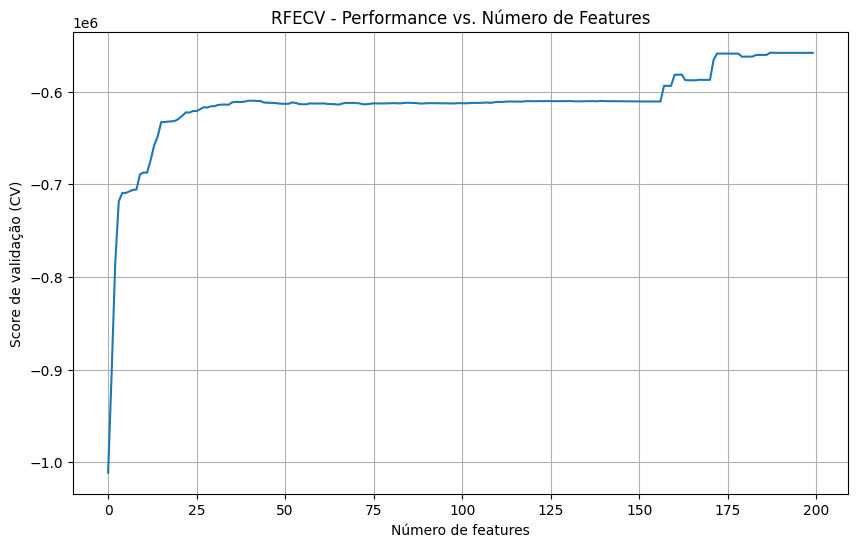

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(rfe.cv_results_['mean_test_score'], '-')
plt.xlabel('Número de features')
plt.ylabel('Score de validação (CV)')
plt.title('RFECV - Performance vs. Número de Features')
plt.grid()
plt.show()

## Treinando o modelo

### MLflow

O MLflow é uma plataforma open-source para gerenciar o ciclo de vida do Machine Learning. Ele permite rastrear experimentos, armazenar modelos e facilitar a implantação. Seus principais componentes incluem o **Tracking** (registro de métricas e parâmetros), **Projects** (padronização de código), **Models** (armazenamento e versionamento) e **Registry** (gestão de modelos para produção).

In [20]:
# Define a URL do servidor MLflow
mlflow.set_tracking_uri('http://127.0.0.1:5000')

# Define o experimento no qual os dados serão registrados
mlflow.set_experiment(experiment_id=542105102691604280)

<Experiment: artifact_location='mlflow-artifacts:/542105102691604280', creation_time=1748625778642, experiment_id='542105102691604280', last_update_time=1748625778642, lifecycle_stage='active', name='price_zapimoveis_santos', tags={}>

In [26]:
with mlflow.start_run():
    # mlflow.sklearn.autolog()

    catboost = CatBoostRegressor(verbose=0, random_state=42)

    param_dist = {
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'depth': [4, 6, 8, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'iterations': [300, 500, 800],
        'bagging_temperature': [0, 0.5, 1.0],
        'random_strength': [1, 5, 10],
    }

    pipe = Pipeline([('scaler', StandardScaler()), ('regressor', catboost)])

    pipe.fit(X_train, y_train)

    # Randomized Search com validação cruzada
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions={
            'regressor__' + k: v for k, v in param_dist.items()
        },
        n_iter=1000,
        scoring='neg_root_mean_squared_error',
        cv=5,
        random_state=42,
        verbose=2,
        n_jobs=-1,
    )

    # Treinamento
    search.fit(X_train, y_train)

    # Melhor modelo e RMSE
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)

    rmse_test = root_mean_squared_error(y_test, y_pred)

    # # Validação cruzada no conjunto de treino
    # cv_rmse = cross_val_score(pipe, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    # rmse_cv_mean = -cv_rmse.mean()

    # cv_mae = cross_val_score(pipe, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    # mae_cv_mean = -cv_mae.mean()

    # cv_r2 = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2')
    # r2_cv_mean = cv_r2.mean()

    # # Métricas no conjunto de teste
    # root_mean_squared_error_test = root_mean_squared_error(y_test, pipe.predict(X_test))
    # mean_absolute_error_test = mean_absolute_error(y_test, pipe.predict(X_test))
    # r2_score_test = r2_score(y_test, pipe.predict(X_test))

    mlflow.log_metrics({
        'RMSE_CV': search.best_score_,
        'RMSE_test': rmse_test,
        #     'MAE_CV': mae_cv_mean,
        #     'MAE_test': mean_absolute_error_test,
        #     'R2_CV': r2_cv_mean,
        #     'R2_test': r2_score_test,
    })

mlflow.end_run()

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
[CV] END regressor__bagging_temperature=1.0, regressor__depth=10, regressor__iterations=500, regressor__l2_leaf_reg=7, regressor__learning_rate=0.05, regressor__random_strength=1; total time= 1.0min
[CV] END regressor__bagging_temperature=1.0, regressor__depth=10, regressor__iterations=500, regressor__l2_leaf_reg=7, regressor__learning_rate=0.05, regressor__random_strength=1; total time= 1.1min
[CV] END regressor__bagging_temperature=1.0, regressor__depth=10, regressor__iterations=500, regressor__l2_leaf_reg=7, regressor__learning_rate=0.05, regressor__random_strength=1; total time= 1.1min
[CV] END regressor__bagging_temperature=1.0, regressor__depth=10, regressor__iterations=500, regressor__l2_leaf_reg=7, regressor__learning_rate=0.05, regressor__random_strength=1; total time= 1.1min
[CV] END regressor__bagging_temperature=1.0, regressor__depth=10, regressor__iterations=500, regressor__l2_leaf_reg=7, regressor__learning_

/home/matheus/projetos/zapimoveis_santos/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END regressor__bagging_temperature=1.0, regressor__depth=8, regressor__iterations=300, regressor__l2_leaf_reg=7, regressor__learning_rate=0.05, regressor__random_strength=10; total time=  11.0s
[CV] END regressor__bagging_temperature=0, regressor__depth=10, regressor__iterations=500, regressor__l2_leaf_reg=3, regressor__learning_rate=0.1, regressor__random_strength=10; total time=  52.3s
[CV] END regressor__bagging_temperature=1.0, regressor__depth=8, regressor__iterations=300, regressor__l2_leaf_reg=7, regressor__learning_rate=0.05, regressor__random_strength=10; total time=  10.3s
[CV] END regressor__bagging_temperature=1.0, regressor__depth=6, regressor__iterations=500, regressor__l2_leaf_reg=9, regressor__learning_rate=0.01, regressor__random_strength=10; total time=   8.3s
[CV] END regressor__bagging_temperature=1.0, regressor__depth=8, regressor__iterations=300, regressor__l2_leaf_reg=7, regressor__learning_rate=0.05, regressor__random_strength=10; total time=  11.3s
[CV] EN

In [42]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', CatBoostRegressor(verbose=0, random_state=42)),
])
pipe.fit(X_train, y_train)

cv_rmse = cross_val_score(
    pipe, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error'
)
-cv_rmse.mean()

CatBoostError: catboost/libs/metrics/metric.cpp:6956: metric/loss-function RMSE do not allows nan value on target

In [69]:
train_df = pd.read_csv('../artifacts/train.csv')
train_df.head()

,codigo_anunciante,codigo_zapimoveis,dtCriacao,dtColeta,imobiliaria,nrPreco,nrCondominio,nrIptu,endereco,nrArea(m2),nrQuartos,nrBanheiros,nrVagas,nrAndar,nrSuites,dMobiliado,dPiscina,dElevador,dLavabo,dSauna,dPorcelanato,dInterfone,dAr-condicionado,dAceita animais,dVaranda,dQuintal,dQuadra poliesportiva,dChurrasqueira,dLavanderia,dSistema de alarme,dÁrea de serviço,dJardim,dDepósito,dPlayground,dVista para o mar,dVaranda gourmet,dCozinha,dSalão de festas,dTV à cabo,dArmário na cozinha,dCircuito de segurança,dCondomínio fechado,dAquecimento,dPortaria 24h,dVigia,dEspaço gourmet,dAcademia,dBicicletário,dSala de jantar,dRua asfaltada,dRecepção,dCloset,dZelador,dGuarita blindada,dÁrea de lazer,dPortão eletrônico,dConexão à internet,dBox blindex,dArmário embutido no quarto,dArmário no banheiro,dAcesso para deficientes,dEscritório,dSpa,dQuadra de tênis,dQuadra de futebol de salão,dVista para a montanha,dPiscina infantil,dDeck,dSala de massagem,dGramado,dCinema,dQuadra de squash,dCopa,dCozinha americana,dGerador elétrico,dBrinquedoteca,dDespensa,dBar,dLareira,dSalão de jogos,dVaranda fechada com vidro,dMóvel planejado,dJanela de alumínio,dVentilação natural,dJanela grande,dDependência de empregados,dHall de entrada,dBanheiro de serviço,dAmbientes integrados,dPé direito alto,dSala grande,dPiso frio,dHidromassagem,dChurrasqueira na varanda,dArmário embutido,dPraça,dPiscina aquecida,dEspaço teen,dQuarto de serviço,dEscada,...,dEspaço verde / Parque,dForno de pizza,dCentro de estética,dCâmera de segurança,dGuarita,dCoworking,dFogão,dSolarium,dCampo de futebol,dCozinha gourmet,dBanheira,dGesso - Sanca - Teto Rebaixado,dEspaço Pet,dEntrada de serviço,dPiscina privativa,dFechadura digital,dPiso de madeira,dManobrista,dEstacionamento,dMezanino,dSala de almoço,dRonda/Vigilância,dMuro de vidro,dSala pequena,dImóvel de esquina,dAdministração,dChuveiro a gás,dSala de reunião,dSala de massagem.1,dArvorismo,dBiblioteca,dPista de cooper,dCondomínio inteligente,dBar na piscina,dRestaurante,dSalão de convenção,dIsolamento acústico,dEntrada lateral,dEspaço zen,dRedario,dMeio andar,dPiscina coberta,dEstacionamento para visitantes,dQuarto extra reversível,dLoja,dEspaço de beleza,dCobertura coletiva,dCarregador eletrônico para carro e bicicleta,dPiscina semi-olímpica,dColeta seletiva de lixo,dPiso vinílico,dLaje,dVista para lago,dÁrvore frutífera,dOfurô,dIsolamento térmico,dPossui divisória,dMuro e grade,dFreezer,dAreia Branca,dBom Retiro,dBoqueirão,dCampo Grande,dCastelo,dCentro,dEmbaré,dEncruzilhada,dEstuario,dGonzaga,dItararé,dJabaquara,dJosé Menino,dMacuco,dMarapé,dMorro Nova Cintra,dPompeia,dPonta da Praia,dSaboó,dVila Belmiro,dVila Matias,dVila Nova,dCondominio,dIptu,dQuartos,dVagas,dAndar,dSuites,nrQtdComodidades,nrPrecoFixo,nrPrecoFixo_m2,nrIptu_m2,nrCondominio_m2,nrComodos,nrComodos_m2,nrBanheiros_Suites,nrVagas_Quartos,nrCondominio_Andar,dtCriacao_Mes,dtCriacao_Trimestre,dtCriacao_SemanaAno
0,461463,2805364413,2025-05-13,29/05/2025,Usuário Newcore,579660,620,1,"Rua Duque de Caxias, 62 - Campo Grande, Santos...",100,2,3,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1,8,621,6.2100,0.0100,6.2000,6,0.0600,3.0000,0.5000,620.0000,5,2,20
1,1965,2735399634,2024-08-16,29/05/2025,Conceito 013 Imóveis,1400000,1400,750,"Rua Cyra, 24 - José Menino, Santos - SP",210,2,3,2,1,1,1,1,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,23,2150,10.2381,3.5714,6.6667,6,0.0286,3.0

In [70]:
y_train = train_df['nrPreco']
X_train = train_df.drop(
    [
        'nrPreco',
        'codigo_zapimoveis',
        'dtCriacao',
        'codigo_anunciante',
        'imobiliaria',
        'dtColeta',
        'endereco',
    ],
    axis=1,
)

In [72]:
X_train.shape

(3647, 200)

In [73]:
y_train.shape

(3647,)

In [101]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

rfe = RFECV(regressor, step=1, cv=5, scoring='neg_root_mean_squared_error')
X_train = rfe.fit_transform(X_train, y_train)

In [79]:
rfe_columns = rfe.get_feature_names_out()
X_train = pd.DataFrame(X_train, columns=rfe_columns)

In [80]:
X_train.shape

(3647, 188)

In [81]:
y_train.shape

(3647,)

In [87]:
train_df = pd.concat([X_train, y_train], axis=1)
train_df.shape

(3647, 189)

In [88]:
pd.read_csv('../artifacts/train_processed.csv').shape

(4859, 189)

In [89]:
test_df = pd.read_csv('../artifacts/test.csv')
test_df.head()

,codigo_anunciante,codigo_zapimoveis,dtCriacao,dtColeta,imobiliaria,nrPreco,nrCondominio,nrIptu,endereco,nrArea(m2),nrQuartos,nrBanheiros,nrVagas,nrAndar,nrSuites,dMobiliado,dPiscina,dElevador,dLavabo,dSauna,dPorcelanato,dInterfone,dAr-condicionado,dAceita animais,dVaranda,dQuintal,dQuadra poliesportiva,dChurrasqueira,dLavanderia,dSistema de alarme,dÁrea de serviço,dJardim,dDepósito,dPlayground,dVista para o mar,dVaranda gourmet,dCozinha,dSalão de festas,dTV à cabo,dArmário na cozinha,dCircuito de segurança,dCondomínio fechado,dAquecimento,dPortaria 24h,dVigia,dEspaço gourmet,dAcademia,dBicicletário,dSala de jantar,dRua asfaltada,dRecepção,dCloset,dZelador,dGuarita blindada,dÁrea de lazer,dPortão eletrônico,dConexão à internet,dBox blindex,dArmário embutido no quarto,dArmário no banheiro,dAcesso para deficientes,dEscritório,dSpa,dQuadra de tênis,dQuadra de futebol de salão,dVista para a montanha,dPiscina infantil,dDeck,dSala de massagem,dGramado,dCinema,dQuadra de squash,dCopa,dCozinha americana,dGerador elétrico,dBrinquedoteca,dDespensa,dBar,dLareira,dSalão de jogos,dVaranda fechada com vidro,dMóvel planejado,dJanela de alumínio,dVentilação natural,dJanela grande,dDependência de empregados,dHall de entrada,dBanheiro de serviço,dAmbientes integrados,dPé direito alto,dSala grande,dPiso frio,dHidromassagem,dChurrasqueira na varanda,dArmário embutido,dPraça,dPiscina aquecida,dEspaço teen,dQuarto de serviço,dEscada,...,dEspaço verde / Parque,dForno de pizza,dCentro de estética,dCâmera de segurança,dGuarita,dCoworking,dFogão,dSolarium,dCampo de futebol,dCozinha gourmet,dBanheira,dGesso - Sanca - Teto Rebaixado,dEspaço Pet,dEntrada de serviço,dPiscina privativa,dFechadura digital,dPiso de madeira,dManobrista,dEstacionamento,dMezanino,dSala de almoço,dRonda/Vigilância,dMuro de vidro,dSala pequena,dImóvel de esquina,dAdministração,dChuveiro a gás,dSala de reunião,dSala de massagem.1,dArvorismo,dBiblioteca,dPista de cooper,dCondomínio inteligente,dBar na piscina,dRestaurante,dSalão de convenção,dIsolamento acústico,dEntrada lateral,dEspaço zen,dRedario,dMeio andar,dPiscina coberta,dEstacionamento para visitantes,dQuarto extra reversível,dLoja,dEspaço de beleza,dCobertura coletiva,dCarregador eletrônico para carro e bicicleta,dPiscina semi-olímpica,dColeta seletiva de lixo,dPiso vinílico,dLaje,dVista para lago,dÁrvore frutífera,dOfurô,dIsolamento térmico,dPossui divisória,dMuro e grade,dFreezer,dAreia Branca,dBom Retiro,dBoqueirão,dCampo Grande,dCastelo,dCentro,dEmbaré,dEncruzilhada,dEstuario,dGonzaga,dItararé,dJabaquara,dJosé Menino,dMacuco,dMarapé,dMorro Nova Cintra,dPompeia,dPonta da Praia,dSaboó,dVila Belmiro,dVila Matias,dVila Nova,dCondominio,dIptu,dQuartos,dVagas,dAndar,dSuites,nrQtdComodidades,nrPrecoFixo,nrPrecoFixo_m2,nrIptu_m2,nrCondominio_m2,nrComodos,nrComodos_m2,nrBanheiros_Suites,nrVagas_Quartos,nrCondominio_Andar,dtCriacao_Mes,dtCriacao_Trimestre,dtCriacao_SemanaAno
0,264817F,2809185236,2025-05-26,29/05/2025,Usuário Newcore,379450,300,720,"Rua Sete de Setembro, 34 - Vila Nova, Santos - SP",68,2,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,6,1020,15.0000,10.5882,4.4118,3,0.0441,1.0000,0.5000,300.0000,5,2,22
1,AP04651,2784254114,2025-03-05,29/05/2025,Ricci Consultoria Imobiliaria,1600000,1506,464,"Avenida Doutor Bernardino de Campos - Gonzaga,...",109,3,3,3,22,1,0,1,1,0,1,0,1,0,1,1,0,1,1,0,0,0,0,0,1,1,0,0,1,1,1,1,0,0,1,0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,31,1970,18.073

In [95]:
y_test = test_df['nrPreco']
X_test = test_df.drop(
    [
        'nrPreco',
        'codigo_zapimoveis',
        'dtCriacao',
        'codigo_anunciante',
        'imobiliaria',
        'dtColeta',
        'endereco',
    ],
    axis=1,
)

In [96]:
X_test.shape

(1563, 200)

In [97]:
y_test.shape

(1563,)

In [102]:
X_test = rfe.transform(X_test)

/home/matheus/projetos/zapimoveis_santos/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(


In [103]:
X_test = pd.DataFrame(X_test, columns=rfe_columns)
X_test.shape

(1563, 188)

In [104]:
test_df = pd.concat([X_test, y_test], axis=1)
test_df.shape

(1563, 189)

In [105]:
train_df.shape

(3647, 189)

In [106]:
processed_train_df = pd.read_csv('../artifacts/train_processed.csv')
processed_train_df.shape

(4859, 189)